In [31]:
import pandas as pd
import numpy as np
from tabata.opset import Opset
from dtaidistance import dtw
import matplotlib.pyplot as plt
import sys
import os
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

class DisablePrint:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Désactiver les avertissements spécifiques
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [10]:
input_file = "../Data/normalized/AFL1EB_normalized.h5"
ds = Opset(input_file)
df_target = ds.df
len(ds)


47

In [36]:
df_target["ALT[m]"].values

array([0.00046998, 0.00046998, 0.00046998, ..., 0.00516978, 0.00516978,
       0.00516978], shape=(7429,))

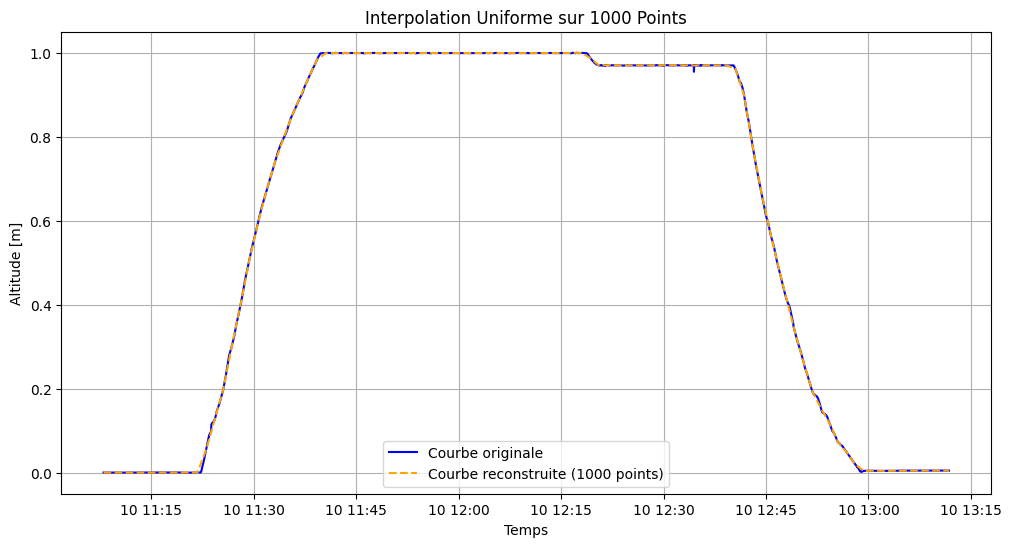

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def interpolate_uniformly(df, num_points, col="ALT[m]"):

    original_times = np.linspace(0, 1, len(df))
    
    target_times = np.linspace(0, 1, num_points)
    
    interp_func = interp1d(original_times, df[col], kind='linear', fill_value="extrapolate")
    interpolated_values = interp_func(target_times)
    
    return pd.DataFrame({"time": target_times, col: interpolated_values})

num_points = 100
interpolated_df = interpolate_uniformly(df_target, num_points, col="ALT[m]")

plt.figure(figsize=(12, 6))

plt.plot(df_target.index, df_target["ALT[m]"], label="Courbe originale", color="blue")

reconstructed_values = np.interp(
    np.linspace(0, 1, len(df_target)),
    interpolated_df["time"],
    interpolated_df["ALT[m]"]
)
plt.plot(df_target.index, reconstructed_values, label="Courbe reconstruite (1000 points)", linestyle="--", color="orange")

plt.xlabel("Temps")
plt.ylabel("Altitude [m]")
plt.title("Interpolation Uniforme sur 100 Points")
plt.legend()
plt.grid()
plt.show()


In [12]:
def optimize_points(df, num_points, col="ALT[m]", max_iter=50, tol=1e-4):

    original_times = np.linspace(0, 1, len(df))
    current_points = np.linspace(0, 1, num_points)  
    prev_error = float("inf")
    
    for iteration in range(max_iter):
        interp_func = interp1d(original_times, df[col], kind='linear', fill_value="extrapolate")
        interpolated_values = interp_func(current_points)
        
        reconstructed_values = np.interp(
            np.linspace(0, 1, len(df)),
            current_points,
            interpolated_values
        )
        
        error = np.mean((df[col].values - reconstructed_values) ** 2)
        print(f"Iteration {iteration + 1}: Reconstruction Error = {error:.6f}")
        
        if abs(prev_error - error) < tol:
            break
        prev_error = error
        
        segment_errors = []
        for i in range(len(current_points) - 1):
            start, end = current_points[i], current_points[i + 1]
            mask = (original_times >= start) & (original_times < end)
            segment_error = np.mean((df[col][mask] - reconstructed_values[mask]) ** 2)
            segment_errors.append(segment_error)
        
        total_error = sum(segment_errors)
        weights = [e / total_error for e in segment_errors]
        new_points = [0]
        for i, weight in enumerate(weights):
            new_points.append(new_points[-1] + weight)
        
        current_points = np.array(new_points) * (1 / new_points[-1])
    
    interp_func = interp1d(original_times, df[col], kind='linear', fill_value="extrapolate")
    interpolated_values = interp_func(current_points)
    return pd.DataFrame({"time": current_points, col: interpolated_values})


c:\Users\ruber\OneDrive\Bureau\MDD\venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning:

A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.

c:\Users\ruber\OneDrive\Bureau\MDD\venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning:

A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.



Generation 1: Best Fitness = 9.184316801999651e-06
Generation 2: Best Fitness = 9.184316801999651e-06
Generation 3: Best Fitness = 6.375547253090874e-06
Generation 4: Best Fitness = 1.2047775347667496e-05
Generation 5: Best Fitness = 8.442893323964113e-06
Generation 6: Best Fitness = 8.442893323964113e-06
Generation 7: Best Fitness = 8.442893323964113e-06
Generation 8: Best Fitness = 8.884471166663031e-06
Generation 9: Best Fitness = 8.884471166663031e-06
Generation 10: Best Fitness = 8.884471166663031e-06
Generation 11: Best Fitness = 8.884471166663031e-06
Generation 12: Best Fitness = 8.884471166663031e-06
Generation 13: Best Fitness = 8.884471166663031e-06
Generation 14: Best Fitness = 8.884471166663031e-06
Generation 15: Best Fitness = 8.884471166663031e-06
Generation 16: Best Fitness = 8.884471166663031e-06
Generation 17: Best Fitness = 8.884471166663031e-06
Generation 18: Best Fitness = 8.884471166663031e-06
Generation 19: Best Fitness = 8.884471166663031e-06
Generation 20: Best 

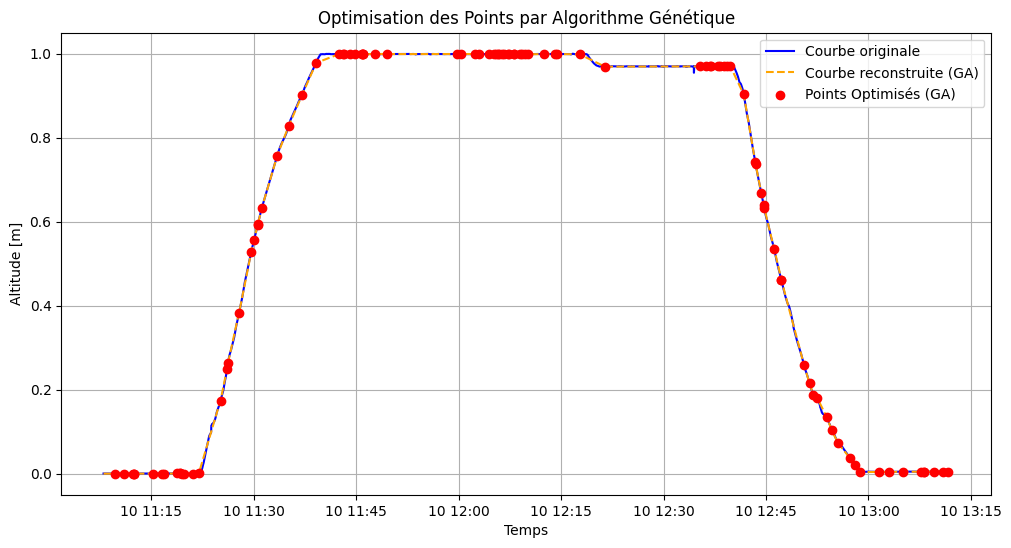

In [15]:
import random
from deap import base, creator, tools
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

def genetic_optimization(df, num_points, col="ALT[m]", generations=50, population_size=20):

    original_times = np.linspace(0, 1, len(df))
    
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimisation
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", lambda: sorted(random.sample(list(original_times), num_points)))
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def evaluate(individual):
        points = individual
        interp_func = interp1d(original_times, df[col], kind="linear")
        interpolated_values = interp_func(points)
        reconstructed_values = np.interp(original_times, points, interpolated_values)
        return mean_squared_error(df[col], reconstructed_values),

    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=population_size)

    for gen in range(generations):
        fitnesses = list(map(toolbox.evaluate, population))
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit
        
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.7:  # Probabilité de croisement
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < 0.2:  # Probabilité de mutation
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        population[:] = offspring

        best_ind = tools.selBest(population, 1)[0]
        print(f"Generation {gen + 1}: Best Fitness = {best_ind.fitness.values[0]}")

    return best_ind

optimized_points = genetic_optimization(df_target, num_points=100, col="ALT[m]")

time_numeric = (df_target.index - df_target.index[0]).total_seconds()

interp_func = interp1d(
    np.linspace(0, 1, len(df_target)), 
    df_target["ALT[m]"], 
    kind="linear", 
    fill_value="extrapolate"
)

time_numeric = (df_target.index - df_target.index[0]).total_seconds()
time_real = np.interp(optimized_points, np.linspace(0, 1, len(time_numeric)), time_numeric)

plt.figure(figsize=(12, 6))
plt.plot(df_target.index, df_target["ALT[m]"], label="Courbe originale", color="blue")

reconstructed_values = np.interp(
    np.linspace(0, 1, len(df_target)), 
    optimized_points, 
    interp_func(optimized_points)
)
plt.plot(df_target.index, reconstructed_values, label="Courbe reconstruite (GA)", linestyle="--", color="orange")

plt.scatter(
    pd.to_datetime(time_real, unit='s', origin=df_target.index[0]),
    interp_func(optimized_points),
    color="red", label="Points Optimisés (GA)", zorder=5
)

plt.xlabel("Temps")
plt.ylabel("Altitude [m]")
plt.title("Optimisation des Points par Algorithme Génétique")
plt.legend()
plt.grid()
plt.show()



Erreurs de reconstruction pour chaque vol :  [6.7934491197263655e-06, 1.1667526419989275e-05, 1.2572594169547423e-05, 5.277496376636322e-06, 7.27699490504446e-06, 6.071800214391187e-06, 6.142045148815561e-06, 1.0248160095874048e-05, 6.725906730331791e-06, 9.740718761022515e-06, 1.4923106262858455e-05, 1.3354038946056232e-05, 1.6085721526649594e-05, 1.1206943338863766e-05, 1.353462164127604e-05, 1.4052726480821943e-05, 6.05446954078124e-06, 9.635323607073377e-06, 2.364119334942712e-05, 8.625674674264359e-06, 1.3988447417601661e-05, 9.517413406630708e-06, 9.488617646557426e-06, 1.4944146055540256e-05, 9.007760068991305e-06, 1.6397801144042622e-05, 8.635080332006824e-06, 1.1676071278153969e-05, 3.542483617263196e-05, 3.3636250897208654e-06, 8.09949385360708e-06, 1.3205249320873195e-05, 3.697352855768631e-05, 7.631007836811316e-06, 6.460562259049176e-06, 7.514419197000931e-06, 6.359757233014715e-06, 1.053358133140579e-05, 1.731825567778778e-05, 4.646616163214733e-06, 6.488900385742148e-06,

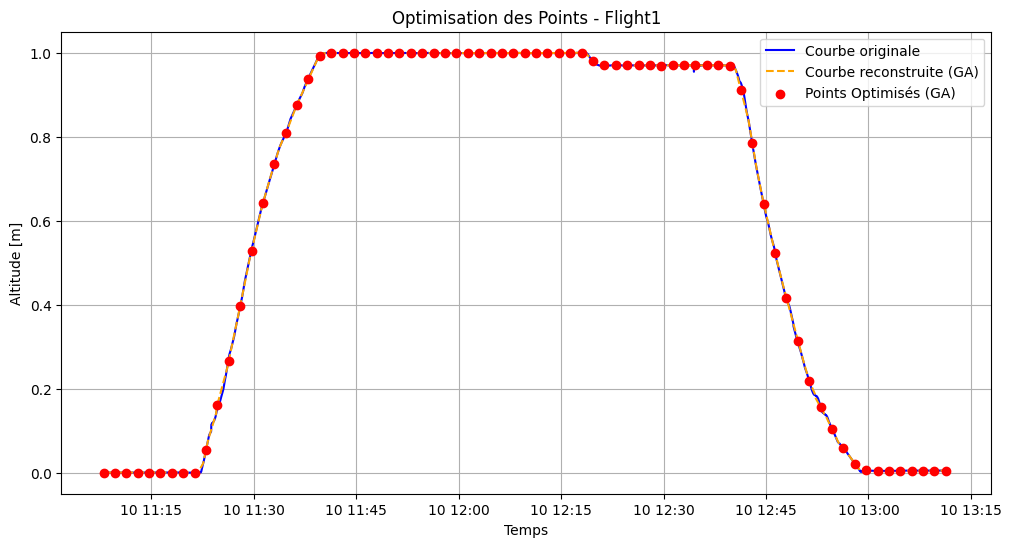

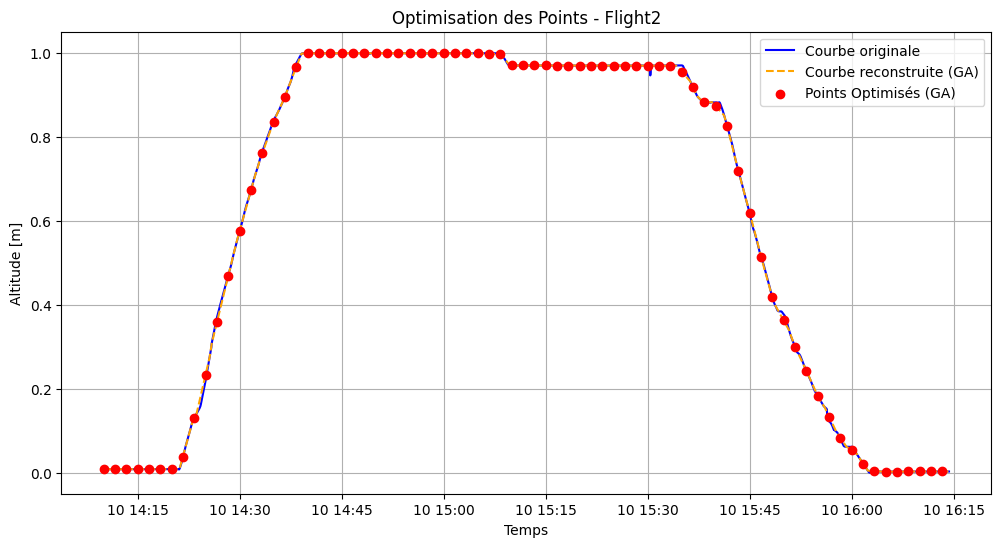

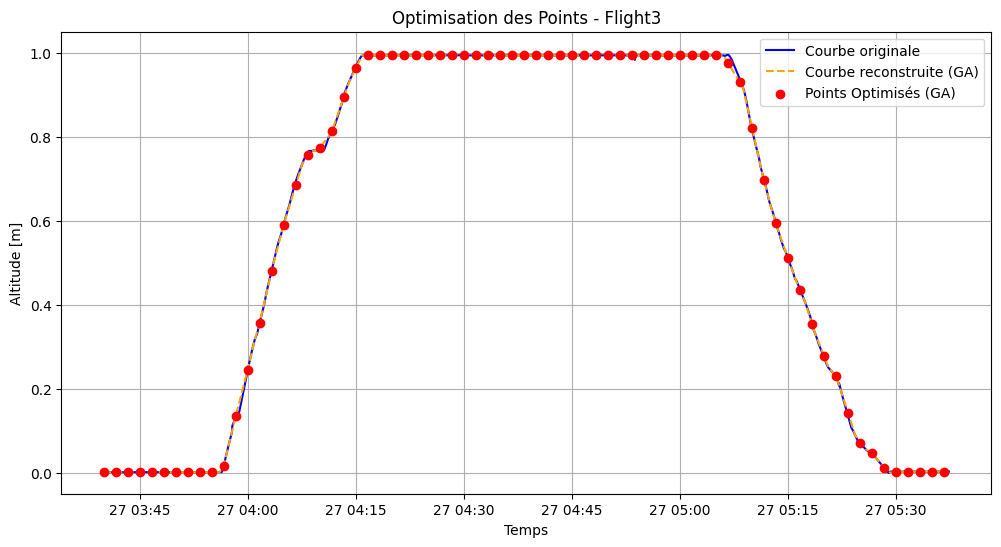

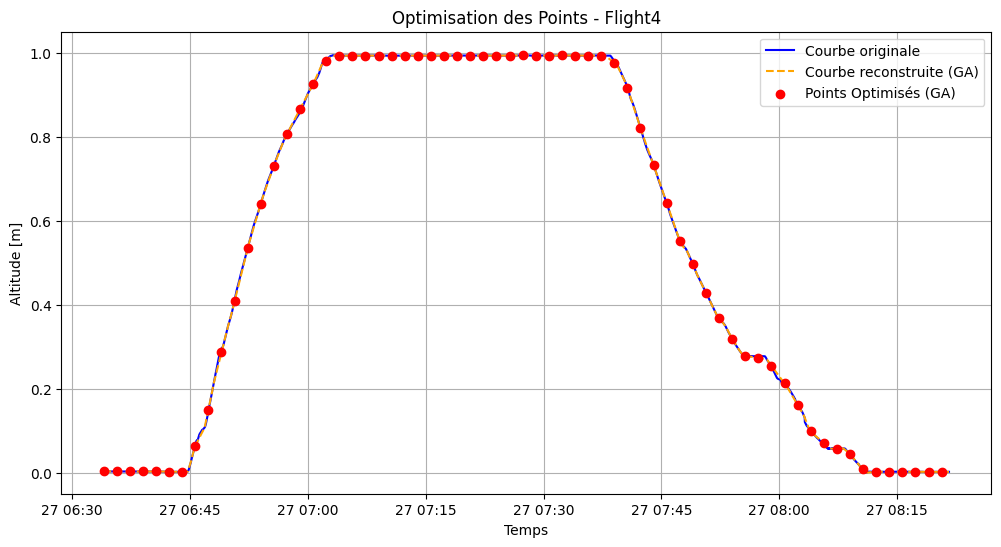

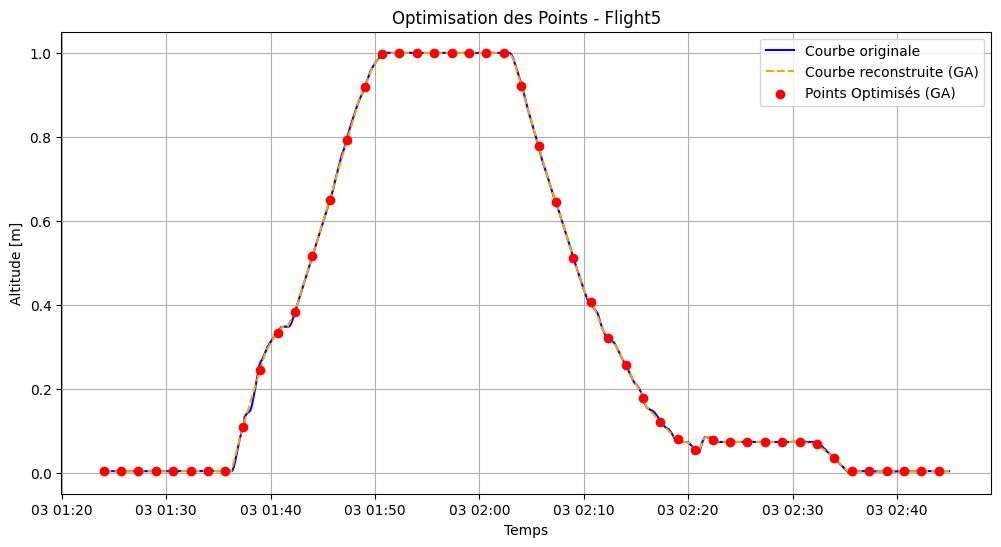

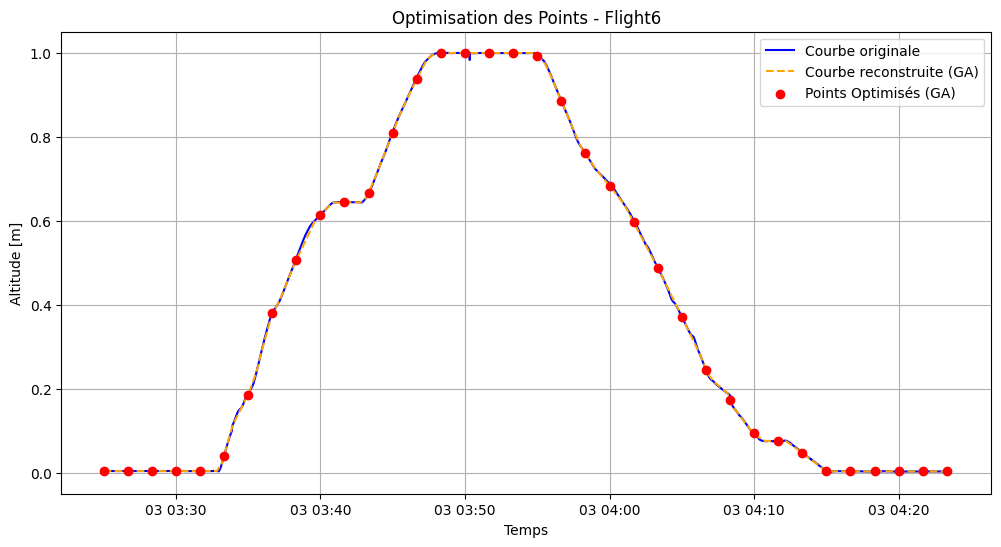

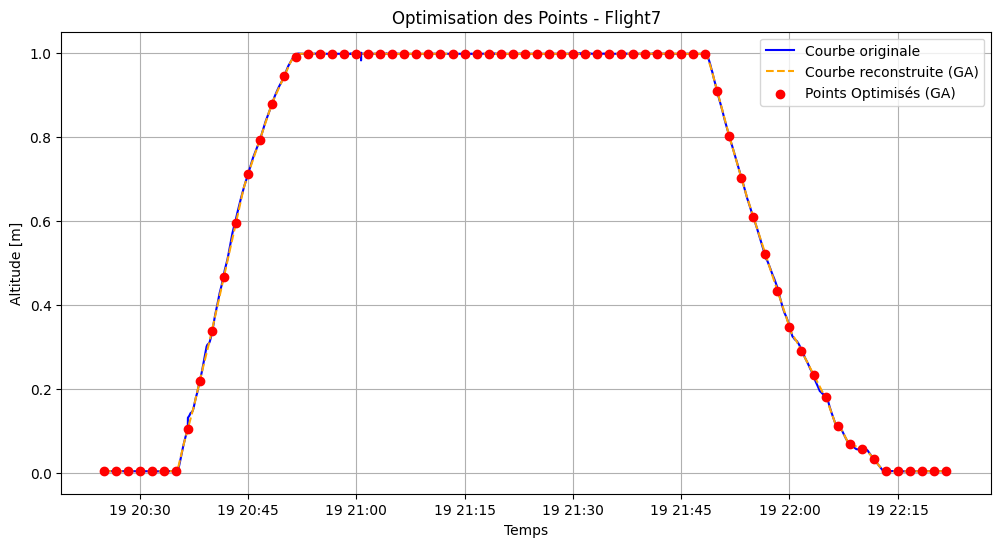

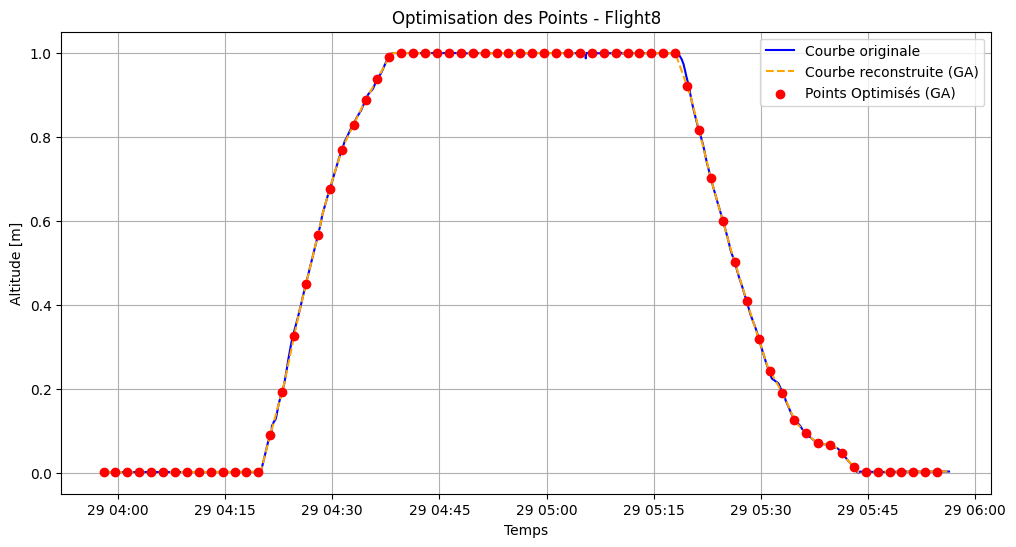

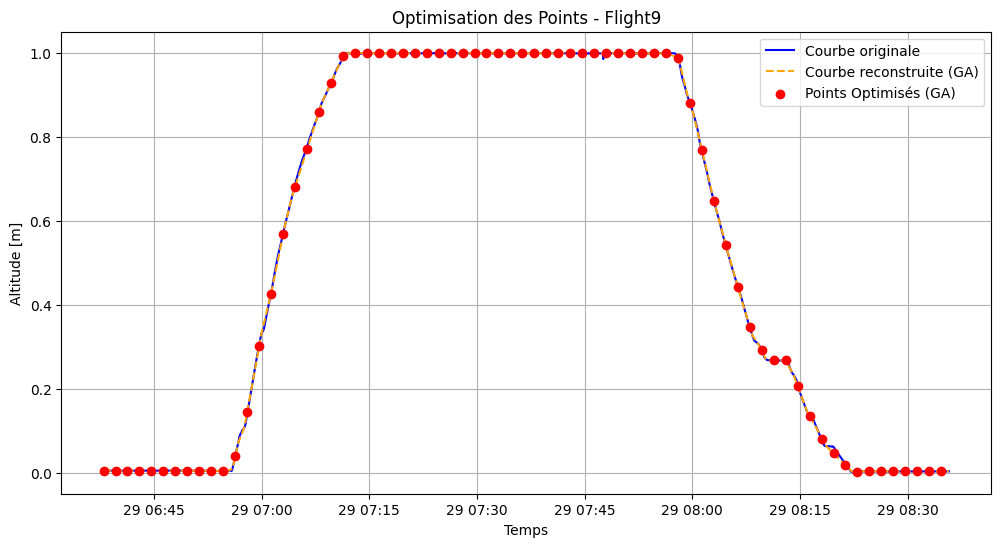

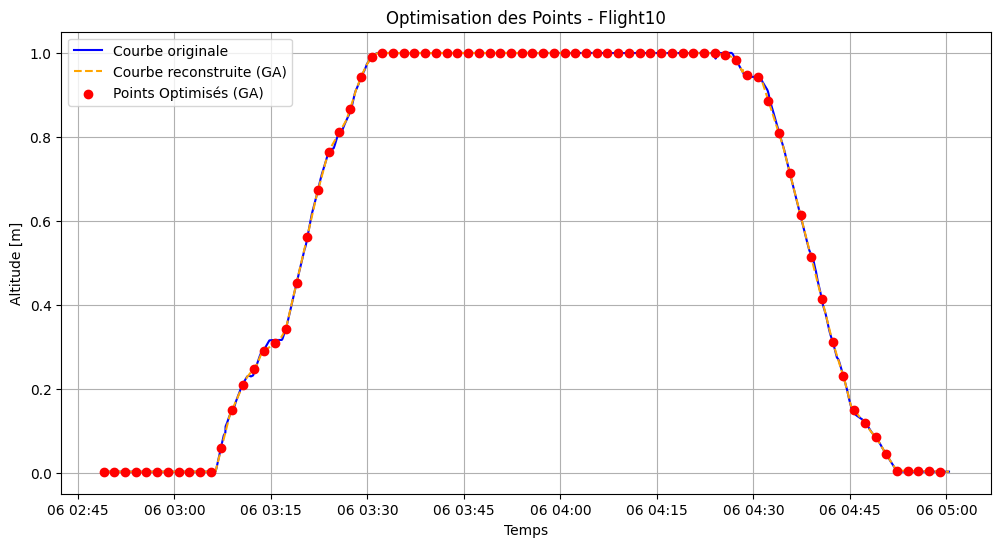

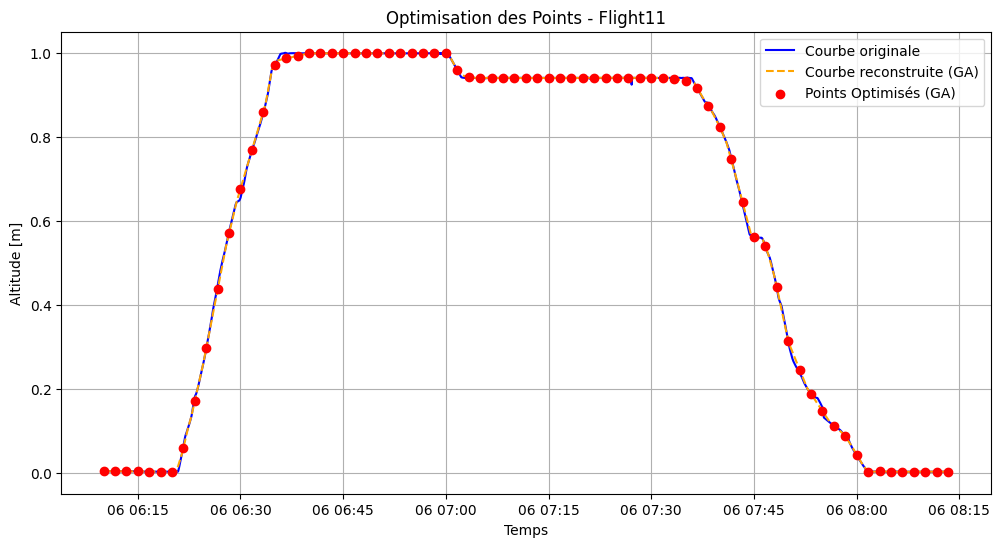

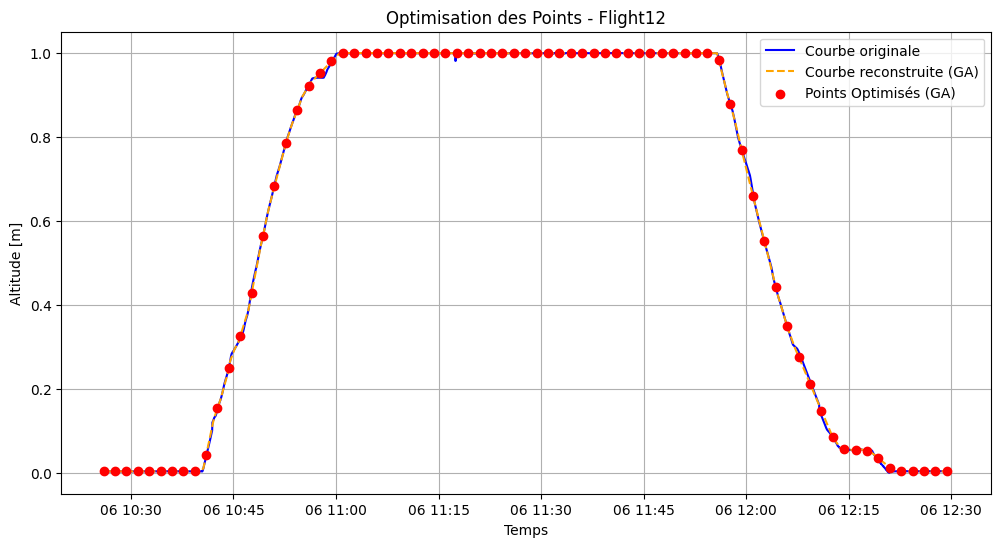

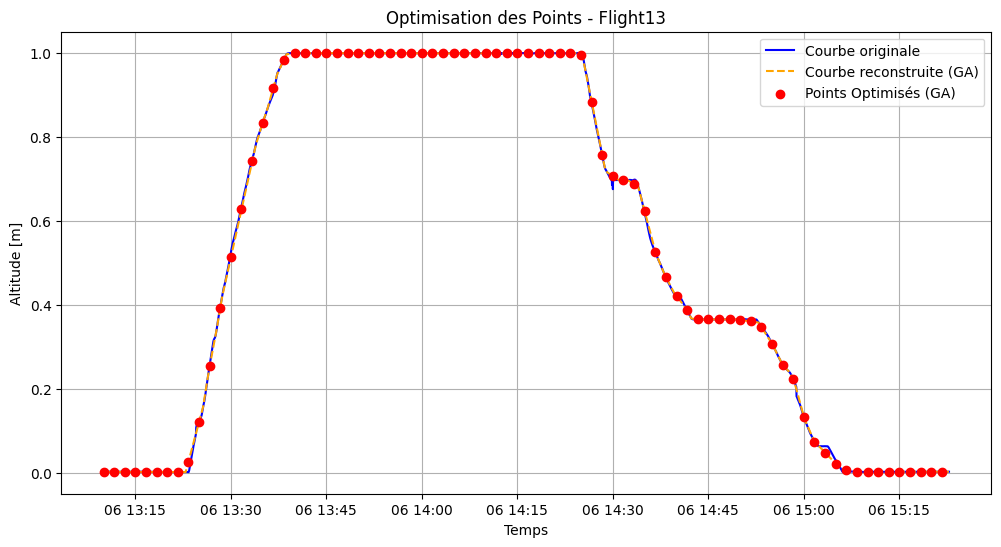

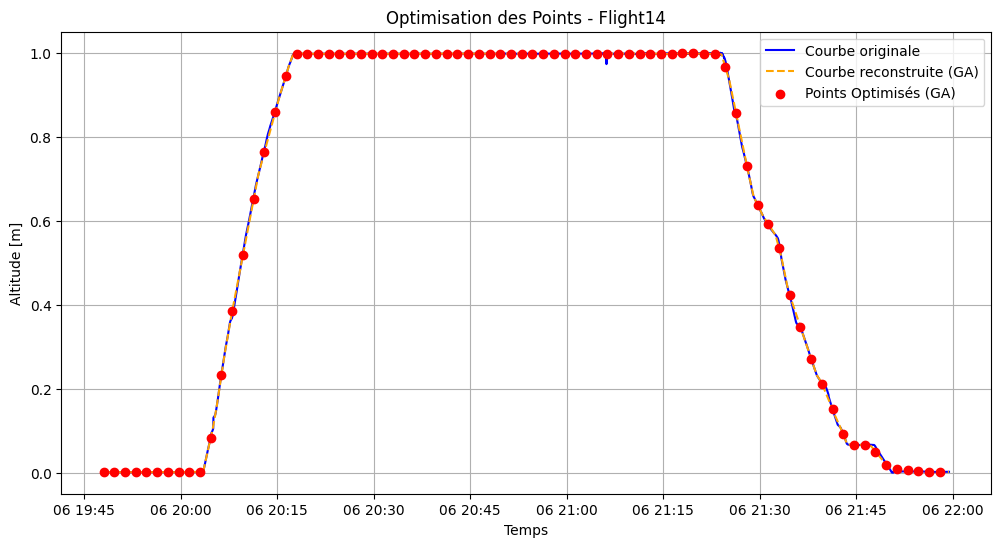

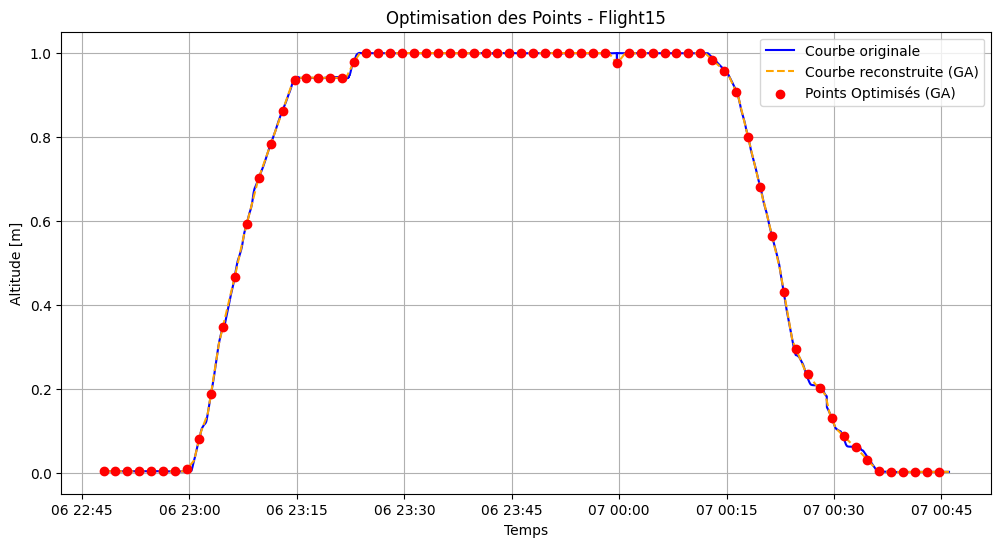

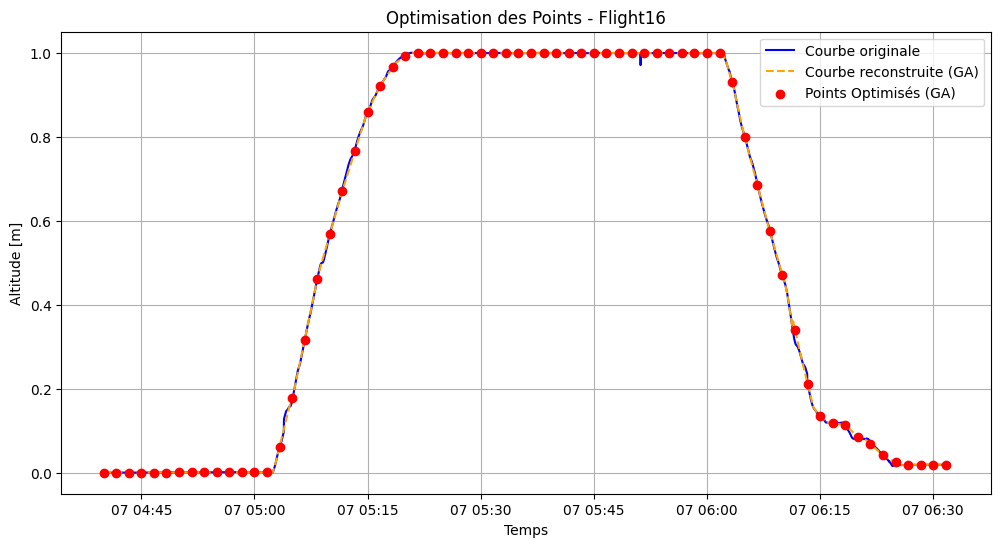

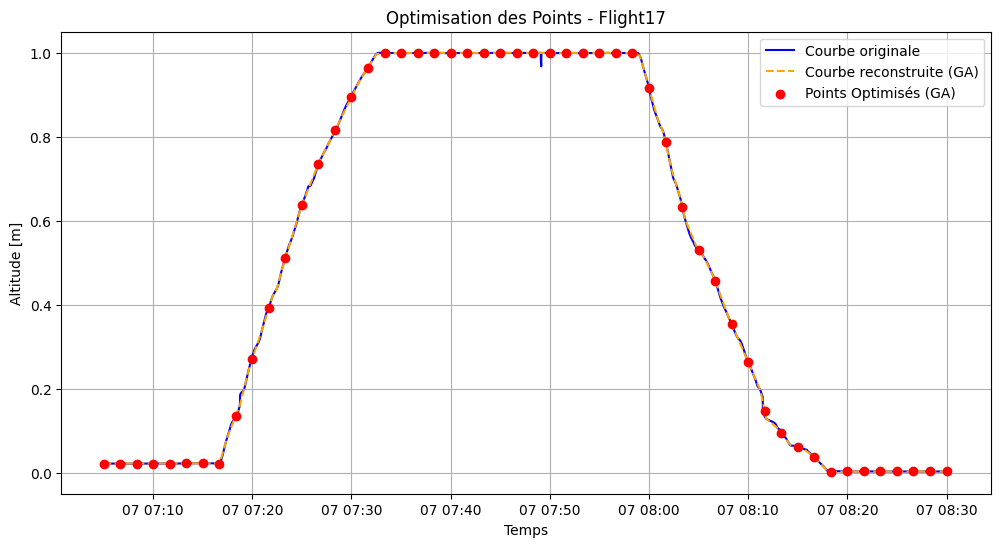

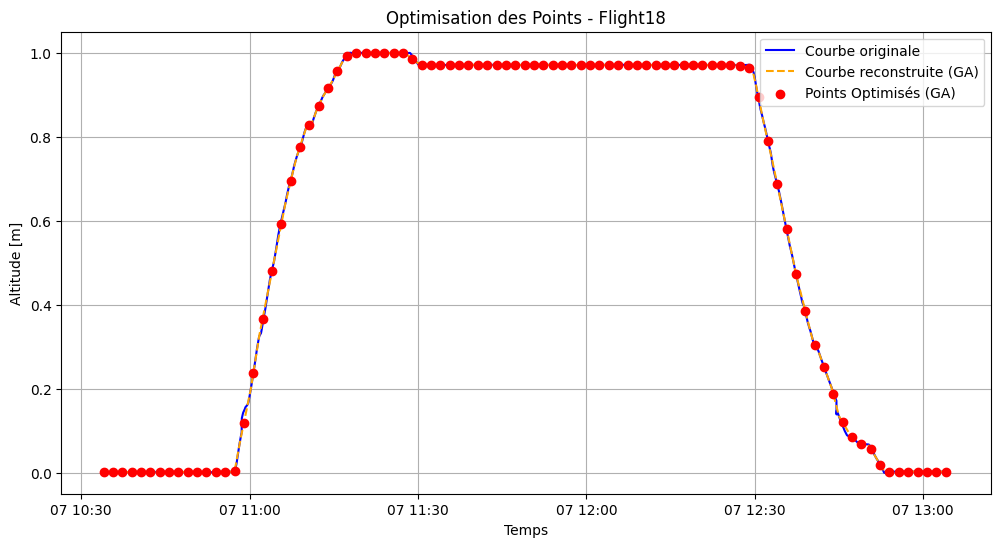

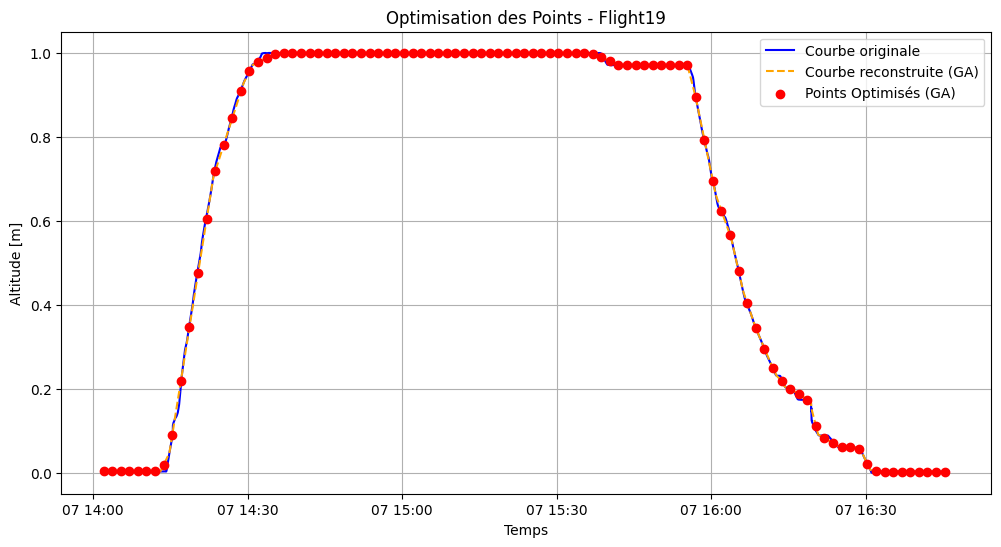

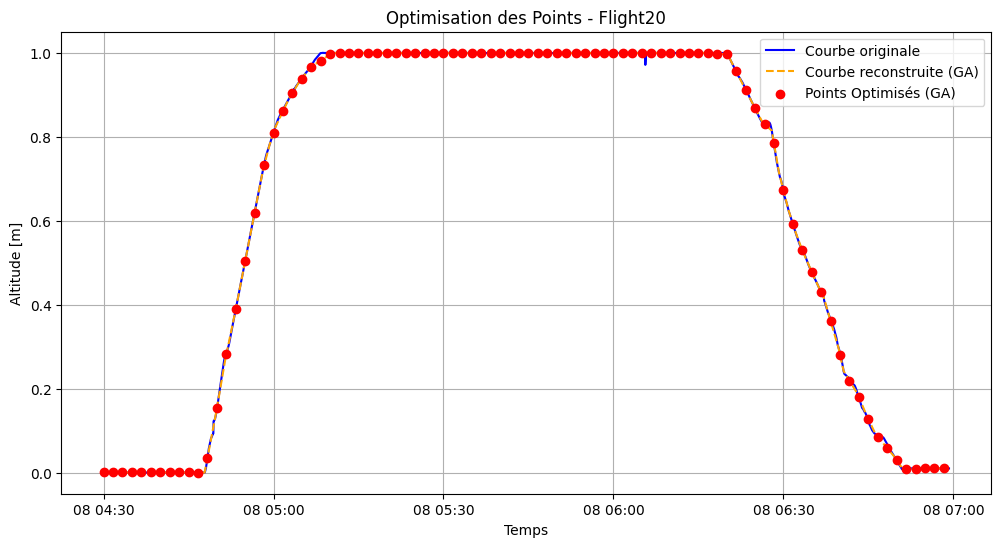

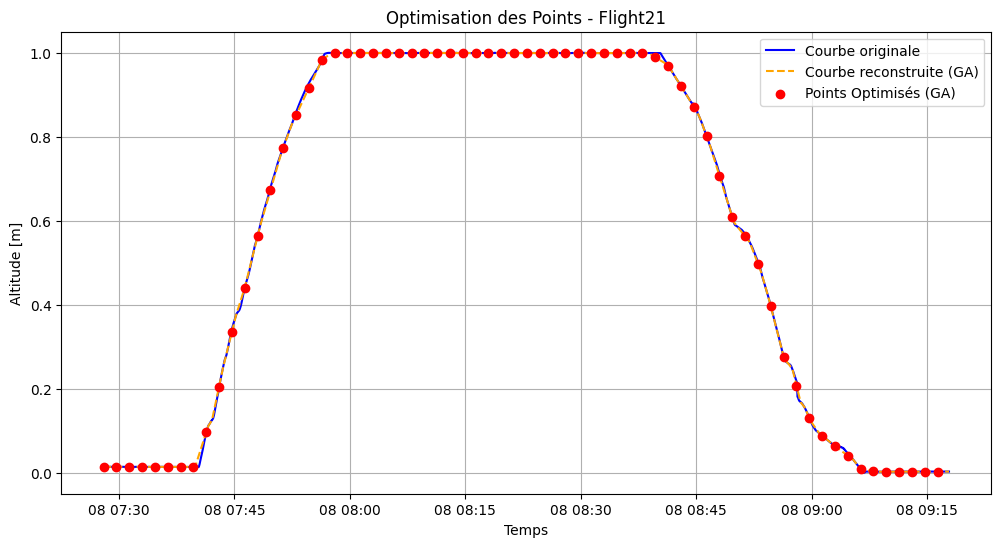

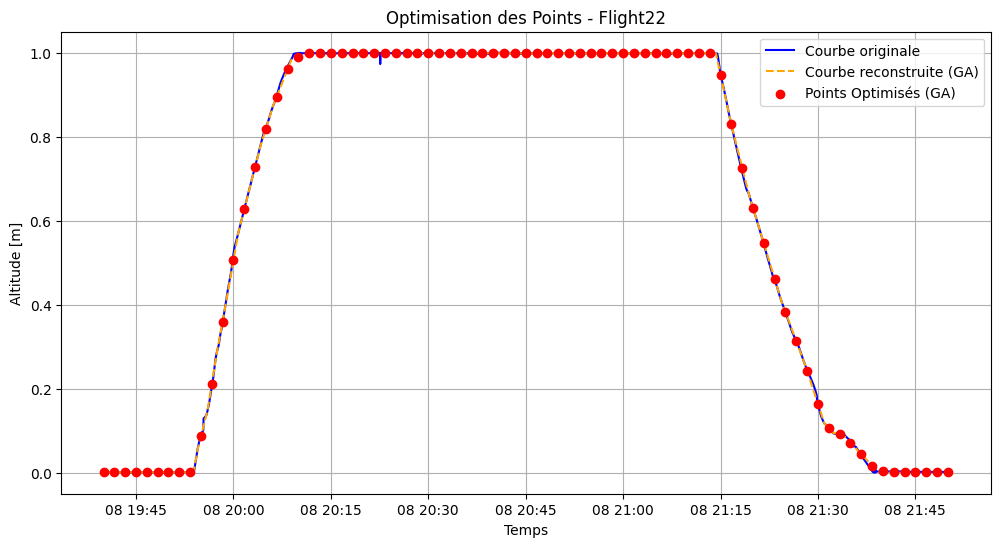

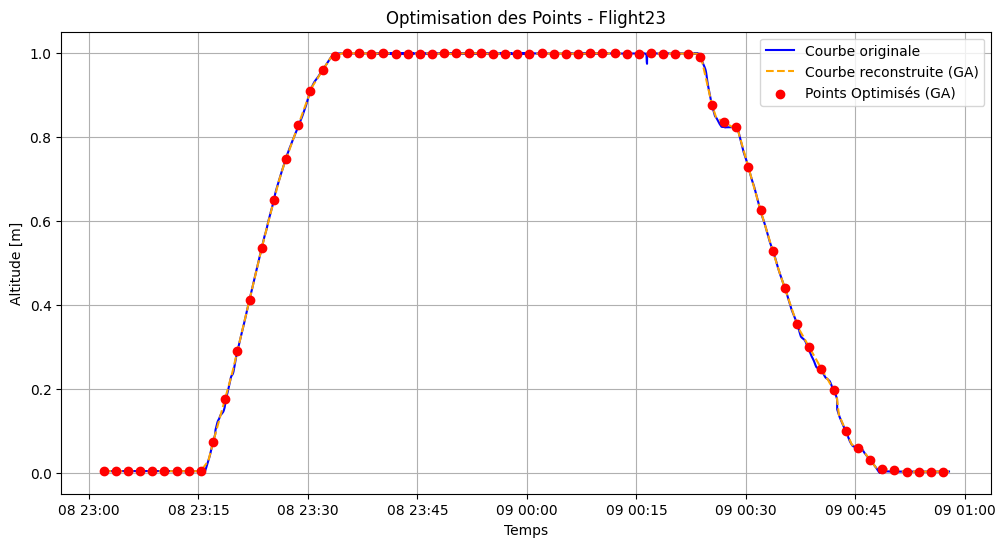

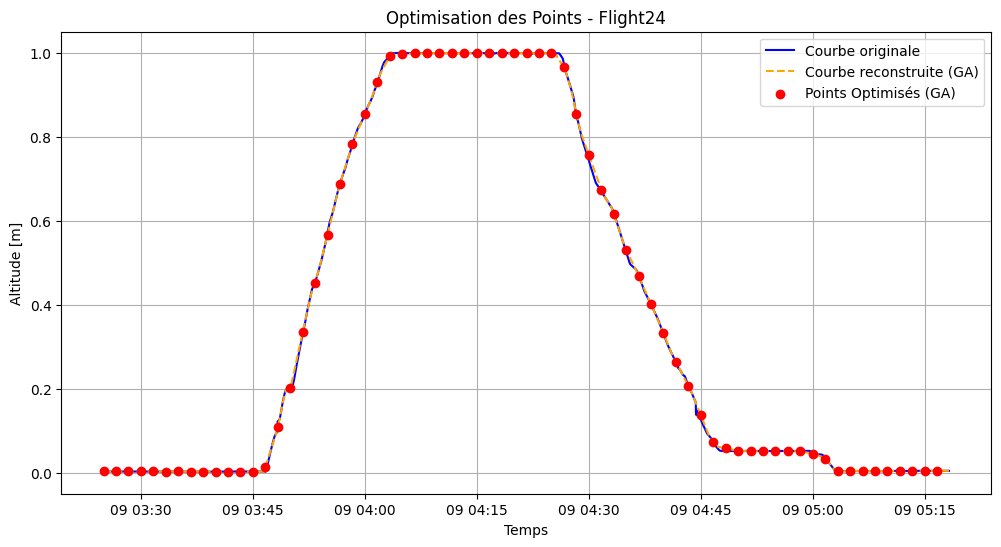

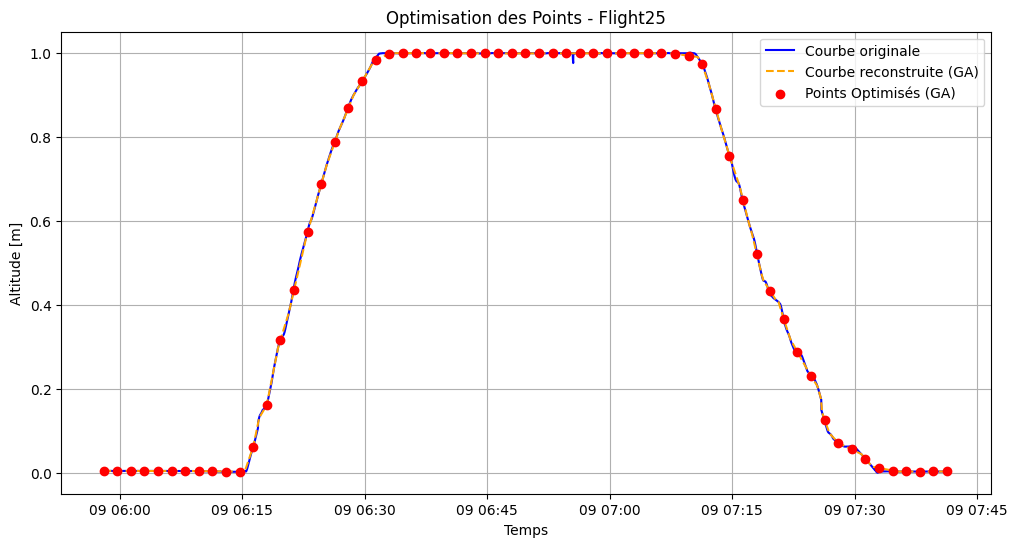

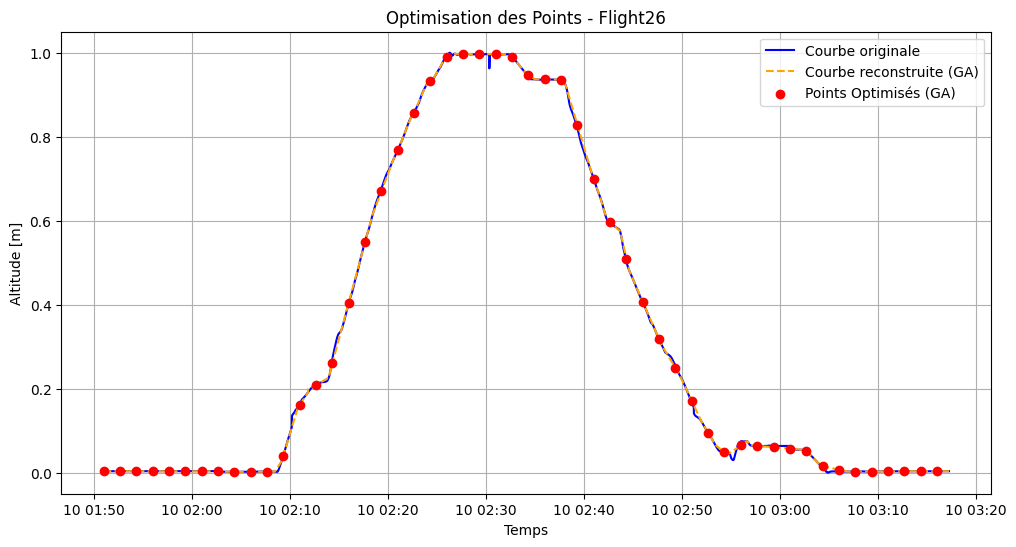

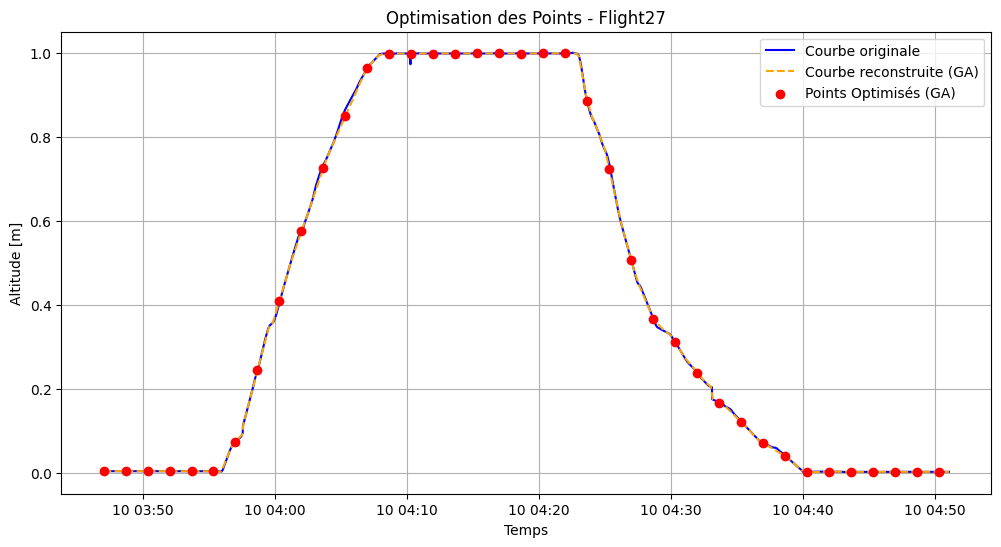

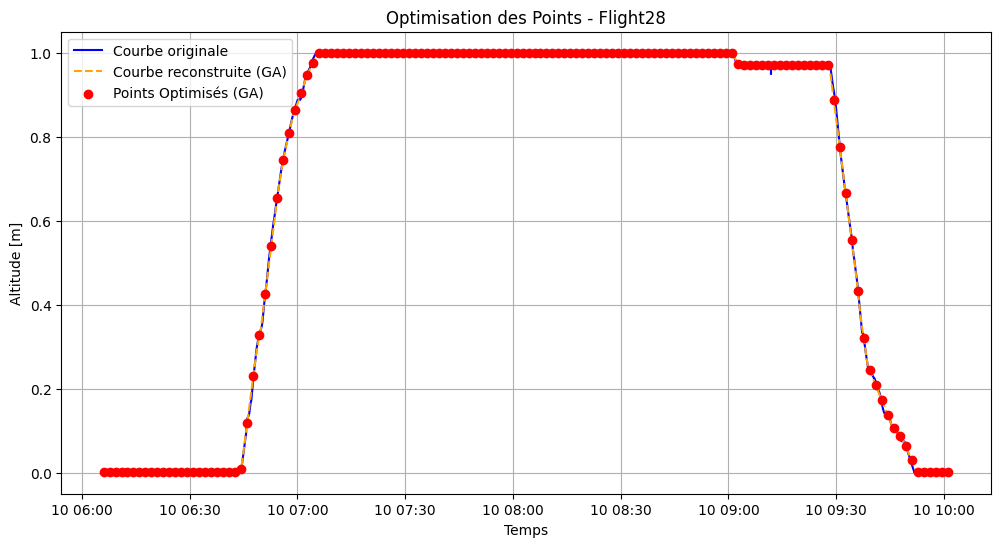

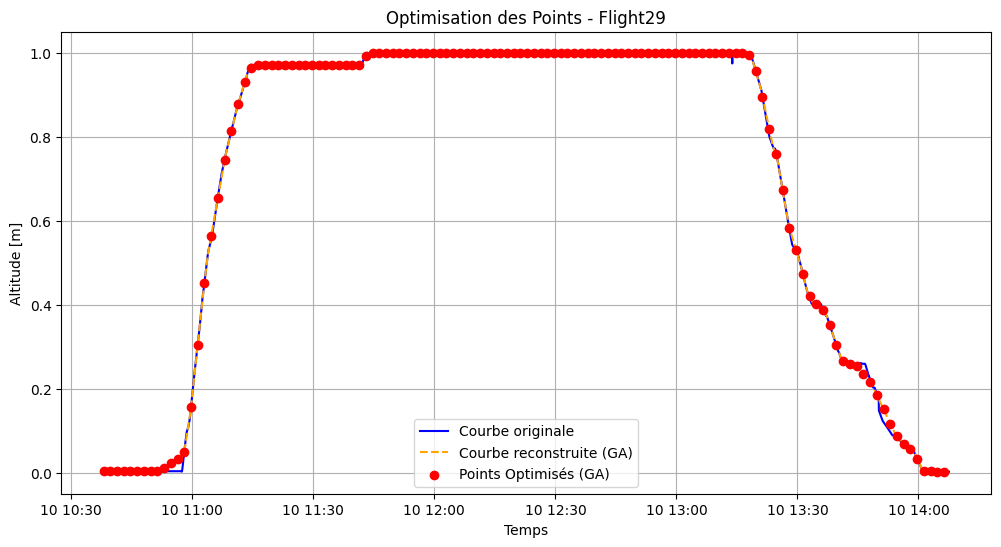

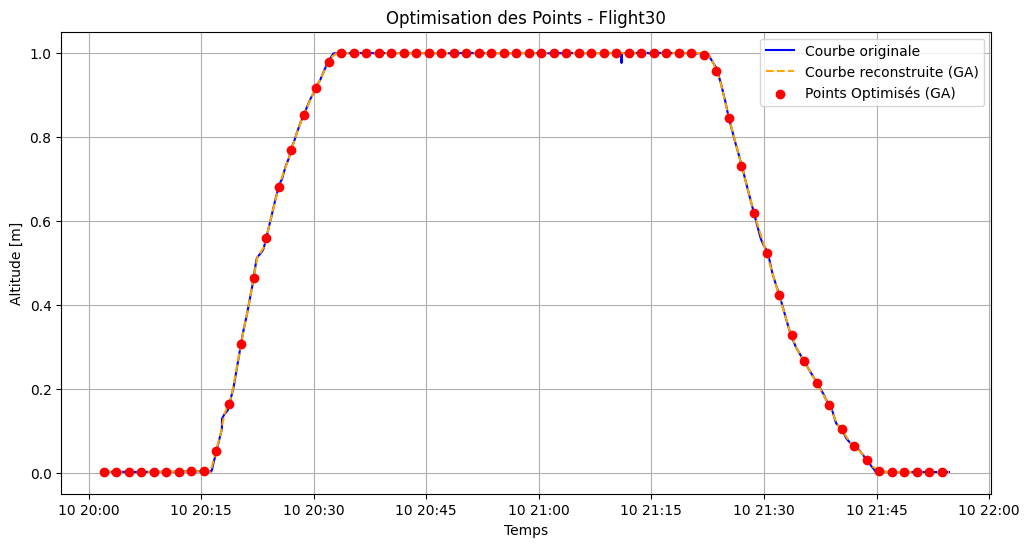

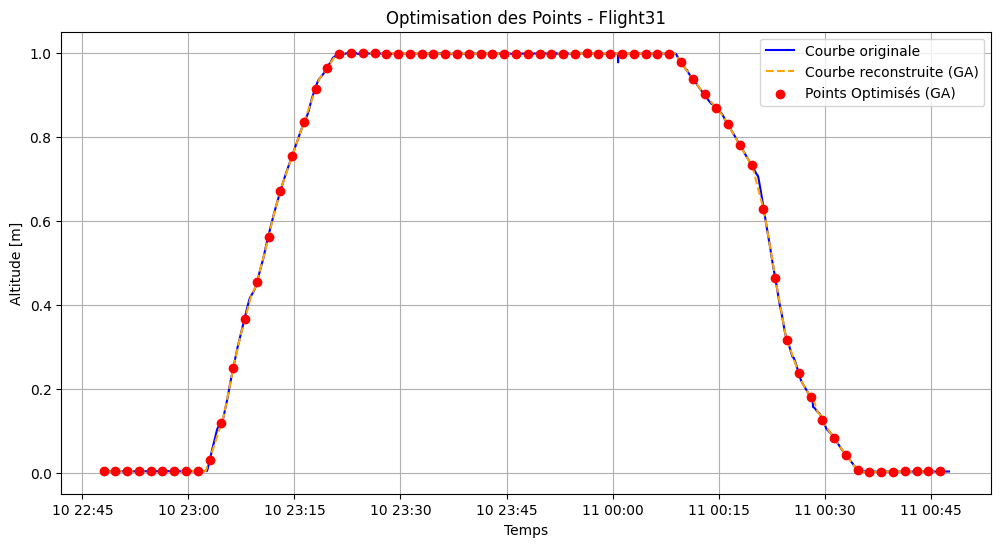

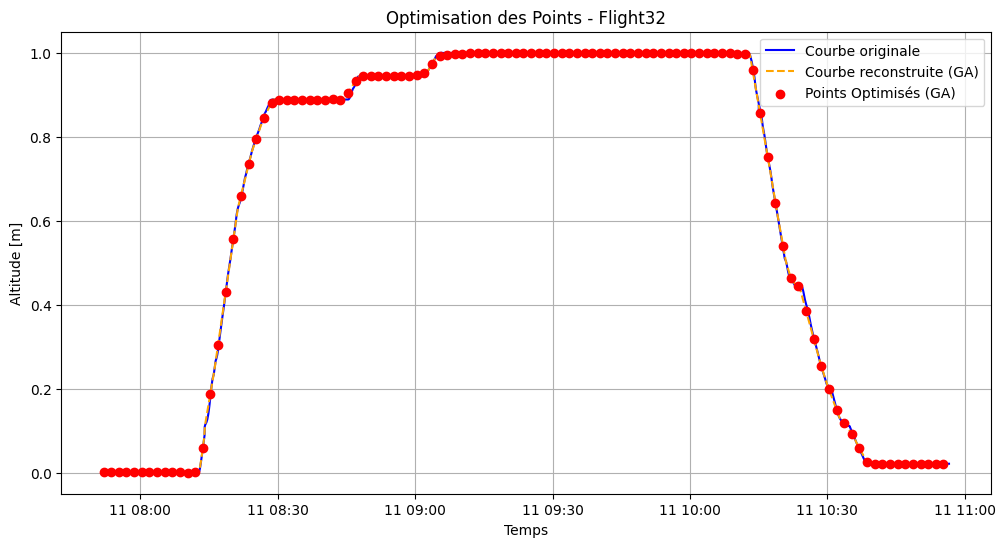

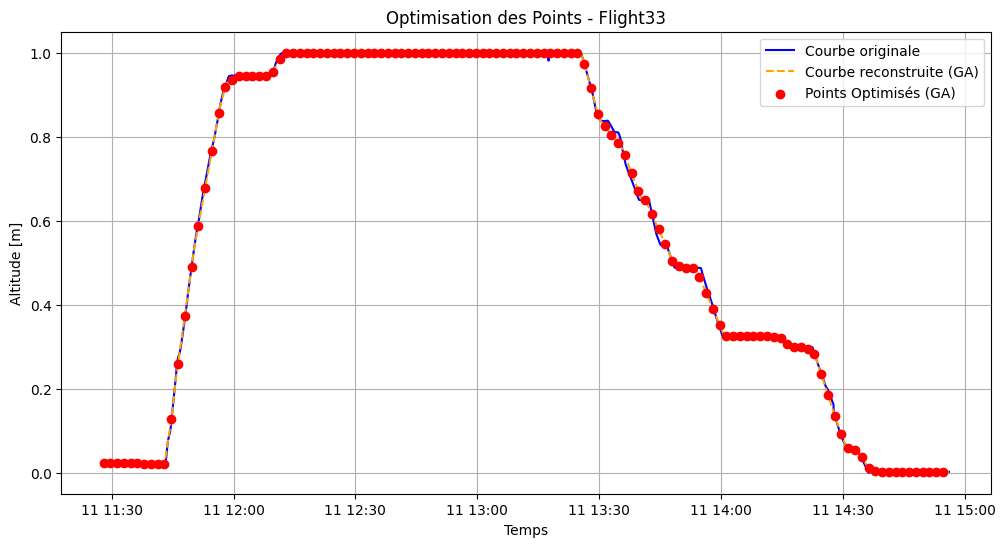

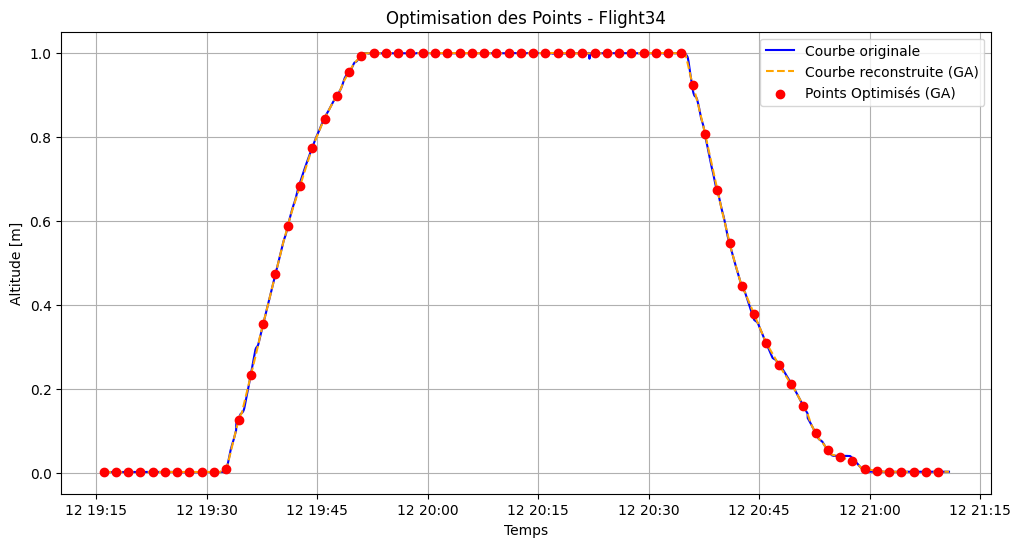

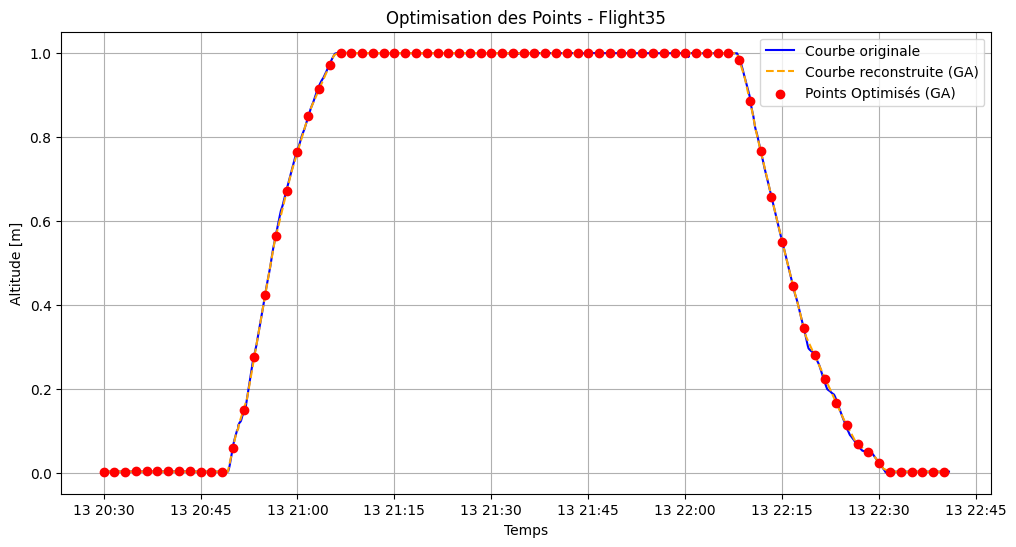

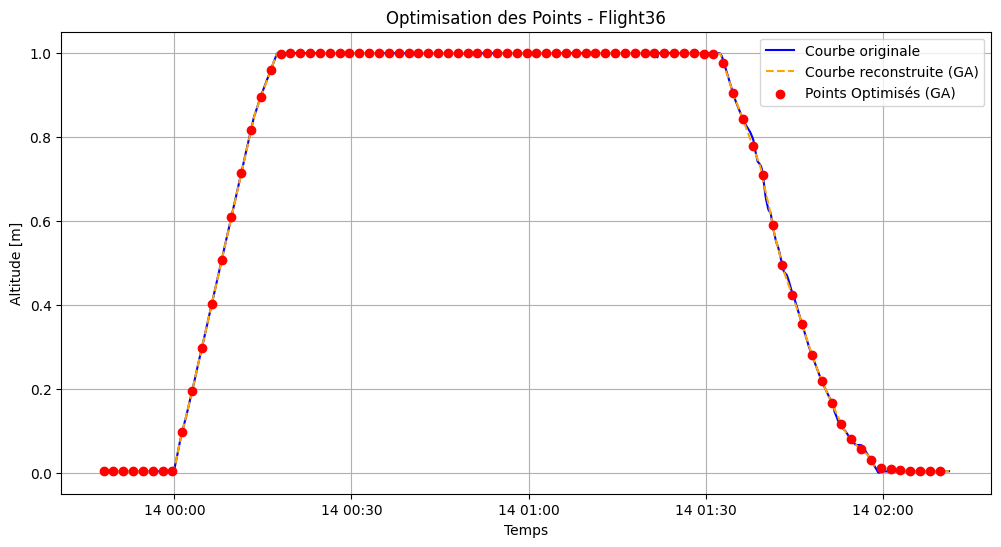

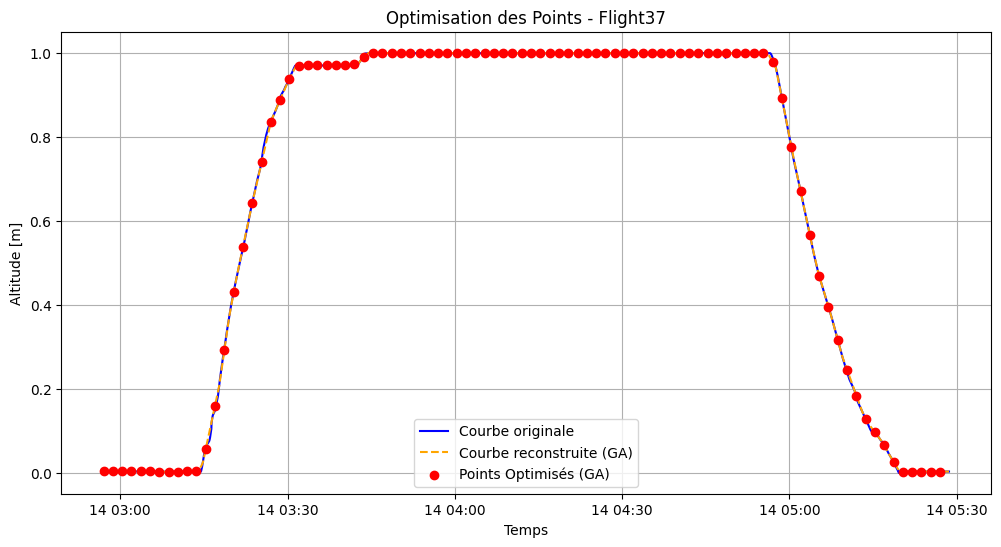

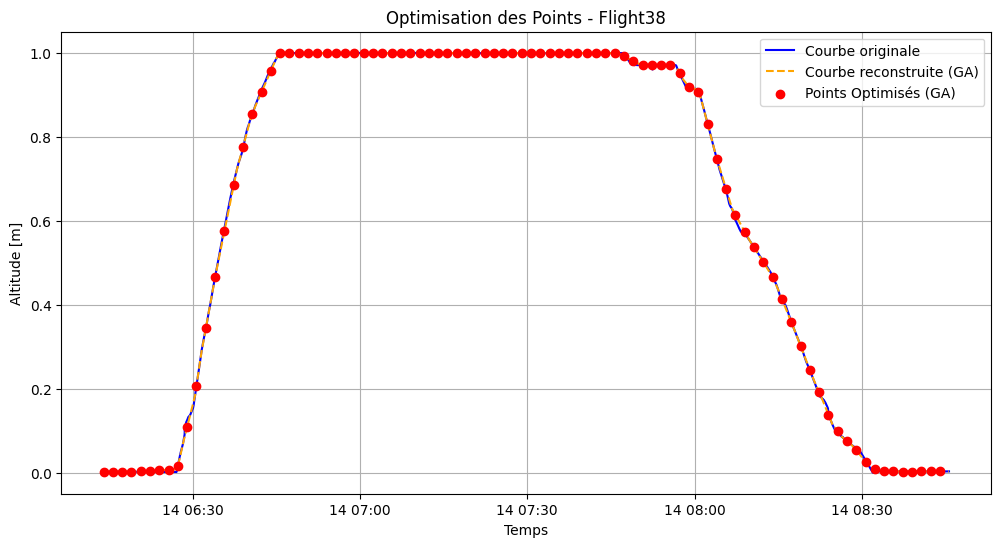

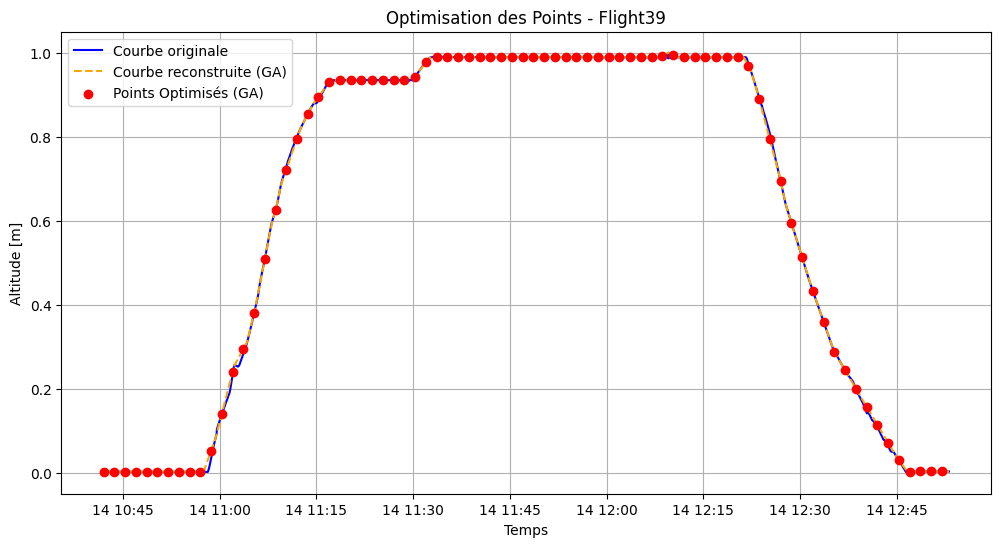

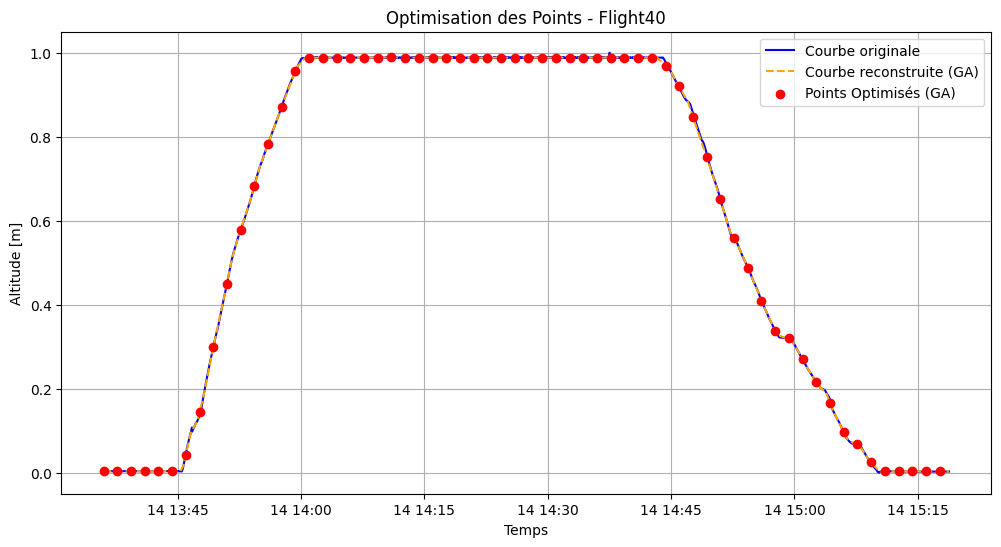

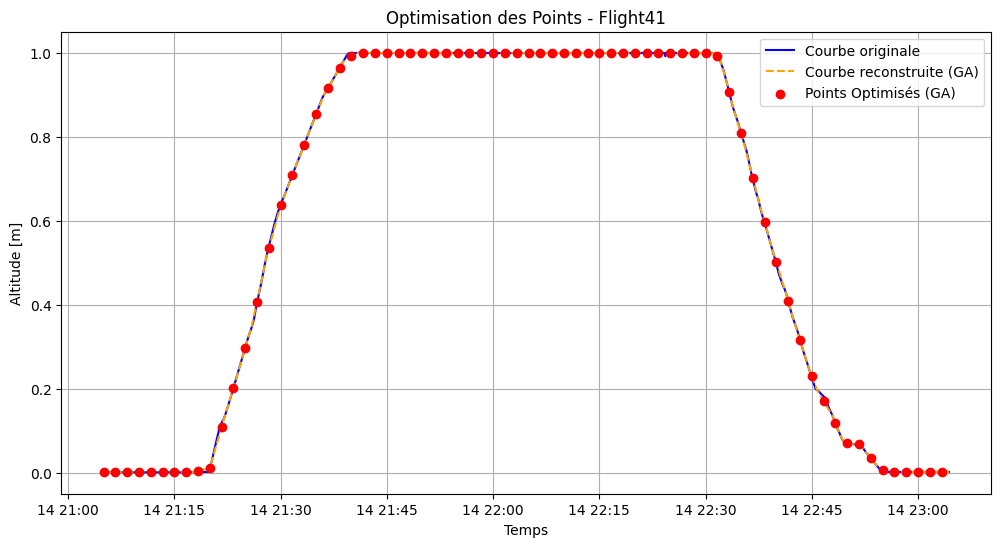

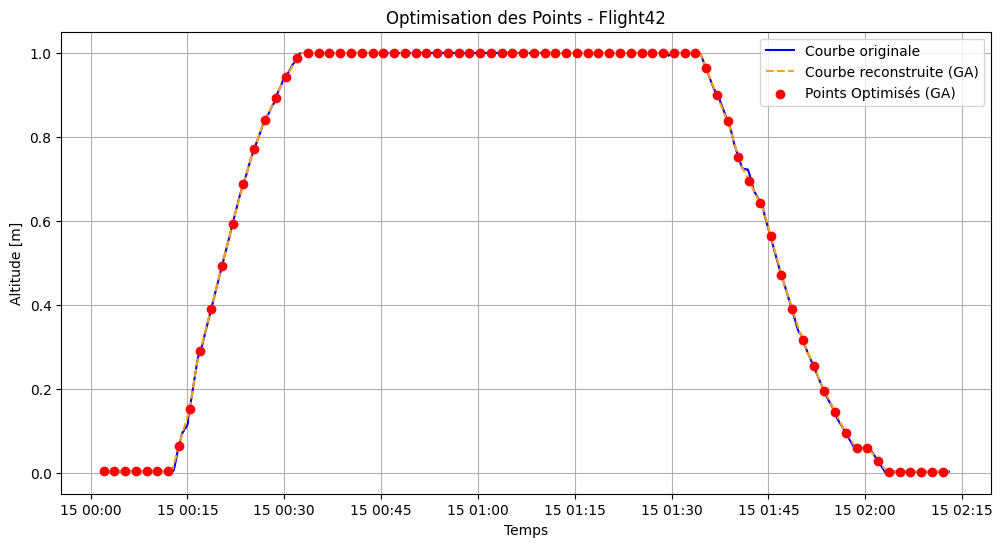

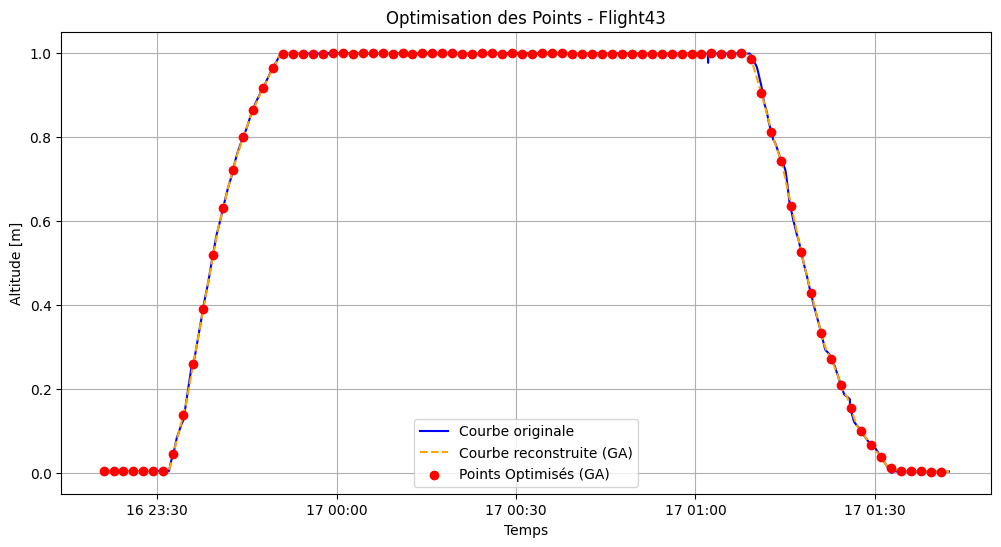

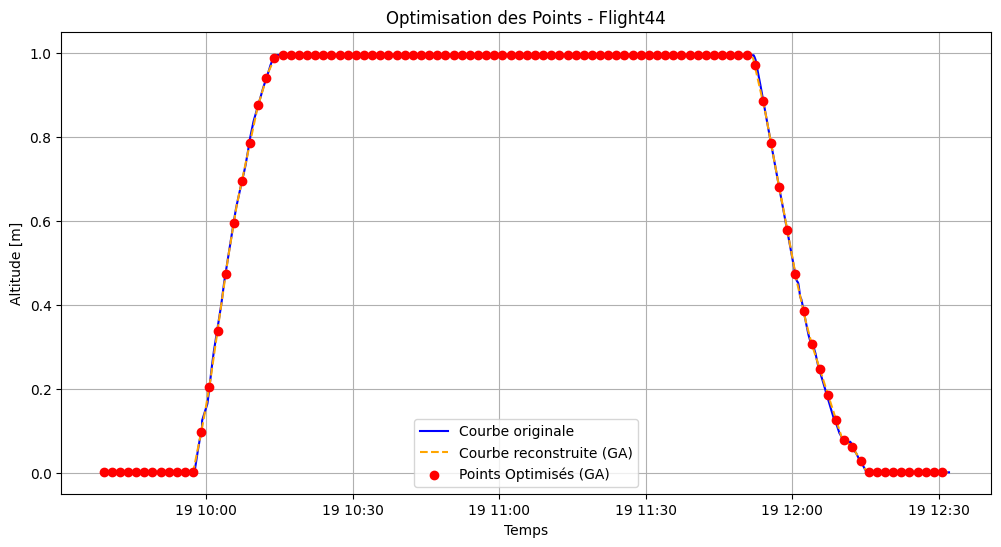

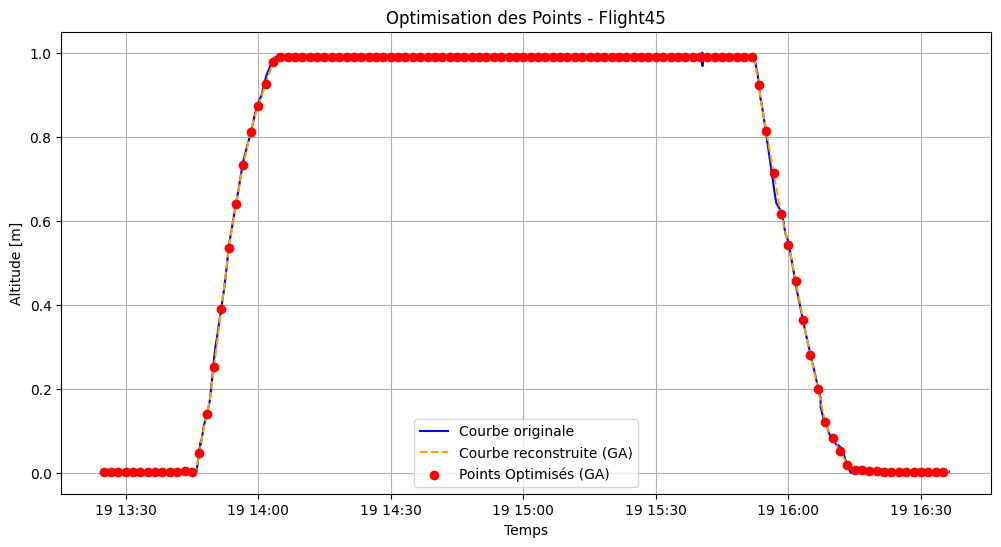

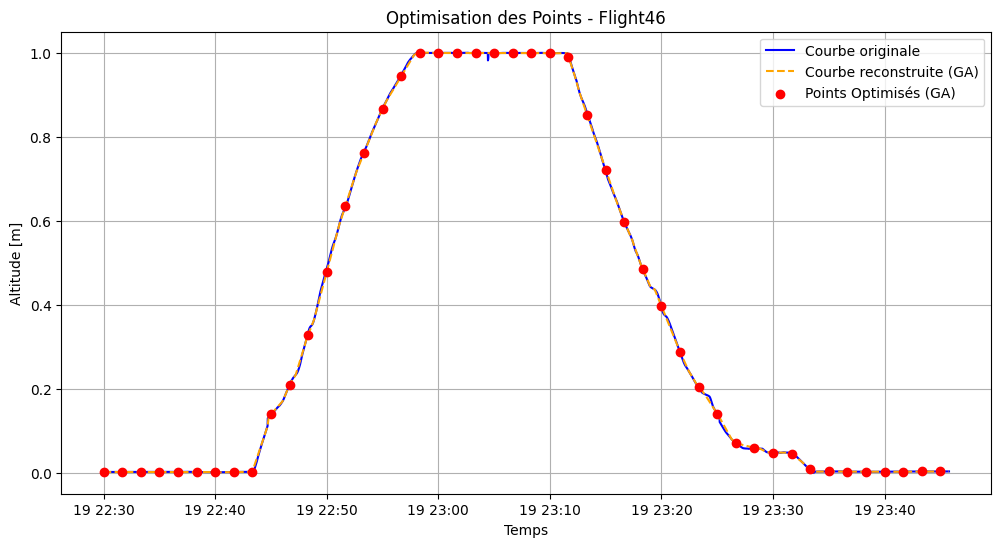

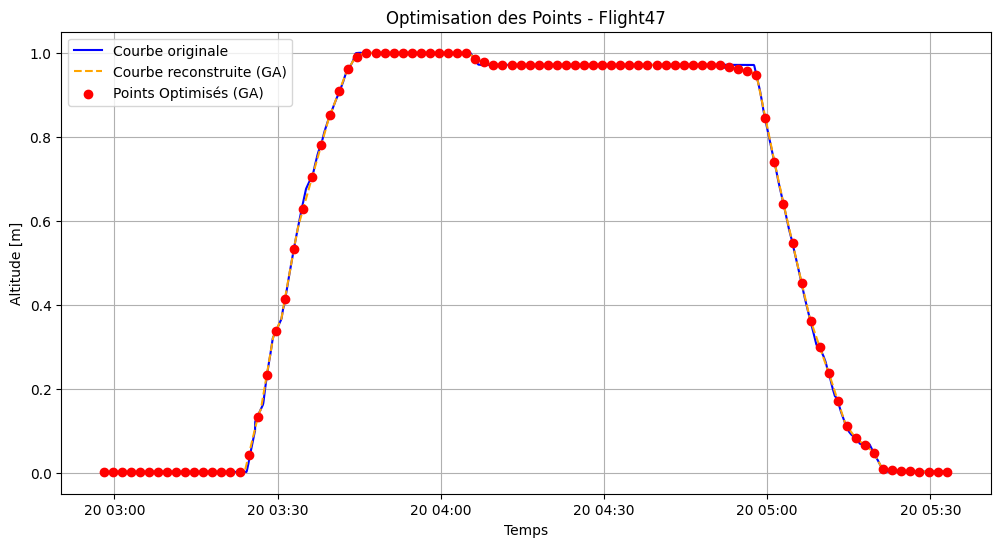

In [32]:
def process_all_flights_with_metrics(Opset, num_points, col="ALT[m]", generations=50, population_size=20):

    all_results = {}
    errors = []
    compressions = []

    for flight_id, df in Opset.items():
        print(f"Processing flight {flight_id}...")

        optimized_points = genetic_optimization(
            df, 
            num_points=num_points, 
            col=col, 
            generations=generations, 
            population_size=population_size
        )
        
        original_times = np.linspace(0, 1, len(df))
        interp_func = interp1d(
            original_times, df[col], kind="linear", fill_value="extrapolate"
        )
        reconstructed_values = np.interp(
            original_times, optimized_points, interp_func(optimized_points)
        )

        mse = mean_squared_error(df[col], reconstructed_values)
        errors.append(mse)

        compression_rate = len(optimized_points) / len(df)
        compressions.append(compression_rate)

        all_results[flight_id] = {
            "optimized_points": optimized_points,
            "reconstructed_values": reconstructed_values,
            "mse": mse,
            "compression_rate": compression_rate,
        }

    global_error = np.mean(errors)

    return all_results, errors, compressions, global_error


Flights = {f"Flight{i+1}": ds[i] for i in range(len(ds))}

with DisablePrint():
    results, errors, compressions, global_error = process_all_flights_with_metrics(
        Flights, num_points=num_points, col="ALT[m]"
    )

print("Erreurs de reconstruction pour chaque vol : ", errors)
print("Taux de compression pour chaque vol : ", compressions)
print("Erreur globale moyenne : ", global_error)

for flight_id in Flights.keys():
    plt.figure(figsize=(12, 6))
    plt.plot(
        Flights[flight_id].index, 
        Flights[flight_id]["ALT[m]"], 
        label="Courbe originale", 
        color="blue"
    )

    plt.plot(
        Flights[flight_id].index,
        results[flight_id]["reconstructed_values"],
        label="Courbe reconstruite (GA)",
        linestyle="--",
        color="orange"
    )

    plt.scatter(
        Flights[flight_id].index[::len(results[flight_id]["optimized_points"])],
        results[flight_id]["reconstructed_values"][::len(results[flight_id]["optimized_points"])],
        color="red",
        label="Points Optimisés (GA)",
        zorder=5
    )

    plt.xlabel("Temps")
    plt.ylabel("Altitude [m]")
    plt.title(f"Optimisation des Points - {flight_id}")
    plt.legend()
    plt.grid()
    plt.show()
